# Oversampling

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR



### Read the CSV

In [3]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

test_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train_initial = pd.read_csv("../model_dev/densenet_data/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv("../model_dev/densenet_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(train_initial.columns)
train_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient02424/study8/view1_frontal.jpg,train/patient02424/study8/view1_frontal.dcm,52.0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,"[0.0036964279133826494, 0.026995880529284477, ..."
1,train/patient08517/study10/view1_frontal.jpg,train/patient08517/study10/view1_frontal.dcm,53.0,0,1,2,0,0,1,1,...,1,0,0,0,0,0,0,0,1,"[0.0035102381370961666, 0.11090341955423355, 0..."
2,train/patient03164/study14/view1_frontal.jpg,train/patient03164/study14/view1_frontal.dcm,80.0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,"[0.005892541725188494, 0.1605752557516098, 0.1..."
3,train/patient28576/study3/view1_frontal.jpg,train/patient28576/study3/view1_frontal.dcm,63.0,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0.0012315319618210196, 0.013657770119607449, ..."
4,train/patient35066/study5/view1_frontal.jpg,train/patient35066/study5/view1_frontal.dcm,59.0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,"[0.0032588730100542307, 0.02126752771437168, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [4]:
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

In [5]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)

In [6]:
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)

### Remove columns

In [7]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [8]:
initial_size = test.shape[0] 
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = valid.shape[0] 
valid = valid[valid['embeddings'].str.len() > 10]
final_size = valid.shape[0] 
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 3


### Convert age to binary to study bias

In [9]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

### Create artificial training distribution

In [10]:
print("Initial sex Distribution:")
print(train['sex'].value_counts())

print("\nInitial Race Distribution:")
print(train['race'].value_counts())

print("\nInitial Age Distribution:")
print(train['age'].value_counts())

print("\nInitial Health Distribution:")
print(train['insurance_type'].value_counts())

Initial sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Initial Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64

Initial Age Distribution:
age
0    42267
1    24929
Name: count, dtype: int64

Initial Health Distribution:
insurance_type
1    43076
2    18340
0     5780
Name: count, dtype: int64


In [16]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
other_cols = ['age', 'sex', 'race', 'insurance_type','embeddings']

train = train[diseases + other_cols]

In [17]:

# Create a list to store resampled data
resampled_data = []

# Determine the size of the largest group based on `sex`, `race`, `insurance_type`
max_size = train.groupby(['sex', 'race', 'age', 'insurance_type']).size().max()

# Loop over each group combination of `sex`, `race`, `insurance_type`
for group, data in train.groupby(['sex', 'race', 'age', 'insurance_type']):

    # Calculate the number of times we need to repeat the data to reach `max_size`
    num_repeats = max_size // len(data)
    remainder = max_size % len(data)

    # Repeat the data `num_repeats` times and add a random sample to reach `max_size`
    resampled_group = pd.concat([data] * num_repeats + [data.sample(remainder, random_state=42)])

    # Append to the list of resampled data
    resampled_data.append(resampled_group)

# Combine all resampled groups back into a single DataFrame
train = pd.concat(resampled_data, ignore_index=True)



In [18]:
train = train.sample(frac=1).reset_index(drop=True)
train = train[:67500]

In [19]:
print("\nFinal sex Distribution:")
print(train['sex'].value_counts())

print("\nFinal Race Distribution:")
print(train['race'].value_counts())

print("\nFinal Age Distribution:")
print(train['age'].value_counts())

print("\nFinal Health Distribution:")
print(train['insurance_type'].value_counts())


Final sex Distribution:
sex
0    33884
1    33616
Name: count, dtype: int64

Final Race Distribution:
race
2    22554
1    22473
0    22473
Name: count, dtype: int64

Final Age Distribution:
age
1    33763
0    33737
Name: count, dtype: int64

Final Health Distribution:
insurance_type
1    22595
2    22467
0    22438
Name: count, dtype: int64


### Train evaluate test

In [20]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())

In [49]:
# Diseases to predict
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

In [50]:
learning_rate = 0.0005
weight_decay = 0
dropout = 0.5
batch_size = 256

# learning_rate = 0.01
# weight_decay = 0
# dropout = 0.5
# batch_size = 256

In [51]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - Convert dataframes to tensors and create dataloaders
X_train = torch.tensor(train_embeddings.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
X_test = torch.tensor(test_embeddings.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)
X_valid = torch.tensor(valid_embeddings.values).float().to(device)
y_valid = torch.tensor(y_valid.values).float().to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
valid_data = TensorDataset(X_valid, y_valid)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


In [52]:

# Assuming y_train is a tensor of shape (num_samples, num_classes)
# where each element is 0 or 1 indicating the absence or presence of a class

def calculate_sample_weights(y_train):
    # Calculate the frequency of each class
    class_counts = y_train.sum(axis=0)
    print(class_counts)
    # Compute the weight for each class (inverse frequency, normalized)
    class_weights = 1. / (class_counts + 1e-5)  # Add a small value to avoid division by zero
    class_weights /= class_weights.sum()  # Normalize so that sum of weights is 1
    print(class_weights)
    
    # Compute the sample weights
    sample_weights = torch.mm(y_train, class_weights.unsqueeze(1)).squeeze()
    
    return sample_weights

sample_weights = calculate_sample_weights(y_train)

# Convert sample weights to a Sampler compatible format
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create DataLoader using the WeightedRandomSampler
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler)


tensor([ 8864., 33421., 16879.,  9885.,  4667., 27721.], device='cuda:0')
tensor([0.2038, 0.0541, 0.1070, 0.1828, 0.3871, 0.0652], device='cuda:0')


In [53]:

# Define a more complex neural network
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(MultiLabelNN, self).__init__()
        # Increase the complexity by adding more layers and a wider network
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(256)  # Batch normalization for the second layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(128, output_size)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [54]:

# # Define the simplified neural network
# class MultiLabelNN(nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MultiLabelNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
#         self.fc3 = nn.Linear(128, output_size)  # Output layer size = number of diseases
#         self.relu = nn.ReLU()  # ReLU activation function
#         self.dropout = nn.Dropout(dropout)  # Dropout for regularization

#     def forward(self, x):
#         x = self.fc1(x)  # First linear transformation
#         x = self.relu(x)  # Activation function
#         x = self.dropout(x)  # Apply dropout
#         x = self.fc3(x)  # Final linear transformation to output size
#         return x


In [55]:
# Calculate weights inversely proportional to class frequencies
class_counts = y_train.sum(axis=0)
class_weights = 1.0 / (class_counts + 1e-5)
class_weights = class_weights / class_weights.mean()  # Normalizing


# Example to increase the weight of positive examples in loss calculation
pos_weights = torch.ones([len(diseases)]).to(device)  # one weight per class
pos_weights *= 5  # Increasing the weights for positive examples

# Use these weights in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


In [56]:
model = MultiLabelNN(1024, len(diseases), dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [57]:
# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.95) 

In [58]:


def train_model(train_loader, validation_loader, model, criterion, optimizer, scheduler, num_epochs):
    model.train()
    training_stats = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_val_loss = 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        training_stats['train_loss'].append(total_loss / len(train_loader))

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        training_stats['val_loss'].append(total_val_loss / len(validation_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

        # Update the learning rate
        scheduler.step()


    return training_stats


Epoch 1/6, Training Loss: 0.5125, Validation Loss: 0.4569
Epoch 2/6, Training Loss: 0.4647, Validation Loss: 0.4451
Epoch 3/6, Training Loss: 0.4434, Validation Loss: 0.4397
Epoch 4/6, Training Loss: 0.4278, Validation Loss: 0.4557
Epoch 5/6, Training Loss: 0.4150, Validation Loss: 0.4433
Epoch 6/6, Training Loss: 0.4019, Validation Loss: 0.4525


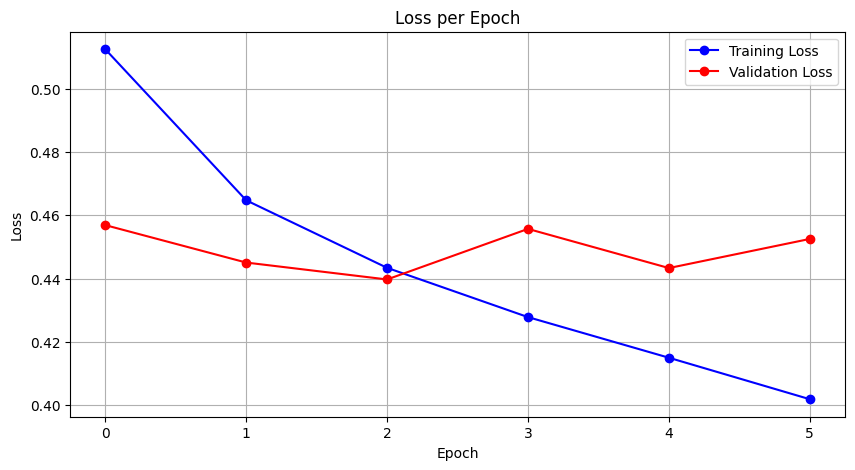

In [59]:
# Run training
nb_epoch = 6
stats = train_model(train_loader, valid_loader, model, criterion, optimizer, scheduler, nb_epoch)

# Plotting the training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [60]:
# Function to evaluate the model
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predicted = torch.sigmoid(output).cpu().numpy()
            all_preds.append(predicted)
            all_targets.append(target.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return all_preds, all_targets

In [61]:
# Evaluate on test data
predictions, targets = evaluate_model(test_loader)

# Create the no finding column
updated_predictions = []

for row in predictions:
    # Check if all elements in the row are less than or equal to 0.5
    if np.all(row <= 0.5):
        new_row = np.append(row, 1)
    else:
        new_row = np.append(row, 0)
    updated_predictions.append(new_row)

predictions = np.array(updated_predictions)

updated_targets = []
for target, no_finding_target in zip(targets, y_no_finding):
    new_target = np.append(target, no_finding_target)
    updated_targets.append(new_target)

targets = np.array(updated_targets)



In [62]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']



In [63]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(predictions, targets)
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.8016473565385664, 'AUC': 0.796220392614421, 'AUPRC': 0.3868776775854375, 'F1 Score': 0.4267584426758443, 'TP Rate': 0.6, 'FN Rate': 0.4, 'TN Rate': 0.8299431352024217, 'FP Rate': 0.17005686479757828}, 'Lung Opacity': {'Accuracy': 0.5279231895204307, 'AUC': 0.6677186031399704, 'AUPRC': 0.6234567472454775, 'F1 Score': 0.1474146428891478, 'TP Rate': 0.08289659342874421, 'FN Rate': 0.9171034065712558, 'TN Rate': 0.9594878561305772, 'FP Rate': 0.04051214386942286}, 'Edema': {'Accuracy': 0.7605874910065249, 'AUC': 0.7734108261723622, 'AUPRC': 0.4877428466959671, 'F1 Score': 0.48329406725208823, 'TP Rate': 0.4659783169850284, 'FN Rate': 0.5340216830149717, 'TN Rate': 0.8537652668016459, 'FP Rate': 0.14623473319835412}, 'Atelectasis': {'Accuracy': 0.7846031706651451, 'AUC': 0.5781320171717659, 'AUPRC': 0.19048066047144802, 'F1 Score': 0.1747148288973384, 'TP Rate': 0.1482258064516129, 'FN Rate': 0.8517741935483871, 'TN Rate': 0.9002843990969596, 'FP Rate': 0.099

### Compute metrics for different categories

In [64]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate
        }

In [65]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUC'] *100
    auc_female = metrics_female[disease]['AUC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female)
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds
0,Cardiomegaly,38.688,79.622,80.000,79.117,0.883,1.129
1,Lung Opacity,62.346,66.772,66.891,66.595,0.296,1.576
2,Edema,48.774,77.341,77.834,76.695,1.139,0.477
3,Atelectasis,19.048,57.813,58.575,56.683,1.892,0.885
4,Pneumothorax,25.349,71.520,70.577,72.796,2.220,1.689
5,Pleural Effusion,68.946,80.345,80.168,80.615,0.447,3.850


In [66]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUC'] *100,
        metrics_black[disease]['AUC'] *100,
        metrics_asian[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds
0,Cardiomegaly,38.688,79.622,79.293,80.393,79.562,1.101,9.046
1,Lung Opacity,62.346,66.772,66.551,68.121,67.091,1.570,2.597
2,Edema,48.774,77.341,77.345,76.319,77.847,1.528,2.780
3,Atelectasis,19.048,57.813,57.840,57.679,57.336,0.503,5.209
4,Pneumothorax,25.349,71.520,70.499,77.036,74.119,6.537,6.239
5,Pleural Effusion,68.946,80.345,80.105,80.075,81.565,1.489,4.243


In [67]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUC'] *100
    auc_young = metrics_young[disease]['AUC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100
    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds
0,Cardiomegaly,38.688,79.622,76.312,81.246,4.934,4.161
1,Lung Opacity,62.346,66.772,63.170,68.492,5.322,3.357
2,Edema,48.774,77.341,75.260,78.241,2.981,5.704
3,Atelectasis,19.048,57.813,56.347,58.738,2.390,1.345
4,Pneumothorax,25.349,71.520,72.058,70.438,1.620,9.273
5,Pleural Effusion,68.946,80.345,79.620,80.638,1.018,4.814


In [68]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUC'] *100,
        metrics_medicare[disease]['AUC'] *100,
        metrics_private[disease]['AUC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds
0,Cardiomegaly,38.688,79.622,81.841,78.552,80.542,3.289,6.894
1,Lung Opacity,62.346,66.772,69.259,65.015,69.519,4.505,2.682
2,Edema,48.774,77.341,76.113,76.325,79.366,3.253,4.843
3,Atelectasis,19.048,57.813,58.265,57.275,59.161,1.885,0.695
4,Pneumothorax,25.349,71.520,71.870,71.506,69.757,2.112,11.933
5,Pleural Effusion,68.946,80.345,80.973,79.681,81.308,1.626,4.510


In [69]:
# Initialize an empty list to store the data
data = []
i=0
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():

    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] + [df_sex['Delta AUC'][i], df_sex['EqOdds'][i]] + [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i]] + [df_age['Delta AUC'][i], df_age['EqOdds'][i]] + [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i]])
    i+=1
# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'Delta AUC sex': "{:.3f}", 
    'EqOdds sex': "{:.3f}",
    'Delta AUC race': "{:.3f}", 
    'EqOdds race': "{:.3f}",
    'Delta AUC age': "{:.3f}", 
    'EqOdds age': "{:.3f}",
    'Delta AUC health': "{:.3f}", 
    'EqOdds health': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC',  'AUPRC', 'Delta AUC sex', 'EqOdds sex', 'Delta AUC race', 'EqOdds race', 'Delta AUC age', 'EqOdds age', 'Delta AUC health', 'EqOdds health'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,Delta AUC sex,EqOdds sex,Delta AUC race,EqOdds race,Delta AUC age,EqOdds age,Delta AUC health,EqOdds health
0,Cardiomegaly,38.688,79.622,0.883,1.129,1.101,9.046,4.934,4.161,3.289,6.894
1,Lung Opacity,62.346,66.772,0.296,1.576,1.570,2.597,5.322,3.357,4.505,2.682
2,Edema,48.774,77.341,1.139,0.477,1.528,2.780,2.981,5.704,3.253,4.843
3,Atelectasis,19.048,57.813,1.892,0.885,0.503,5.209,2.390,1.345,1.885,0.695
4,Pneumothorax,25.349,71.520,2.220,1.689,6.537,6.239,1.620,9.273,2.112,11.933
5,Pleural Effusion,68.946,80.345,0.447,3.850,1.489,4.243,1.018,4.814,1.626,4.510


In [70]:
df.to_csv("data_augmentation_big_nn.csv")

### Study a specific metric and compare

In [71]:
met = 'AUPRC'  #Accuracy, AUC, F1 Score, TP Rate, FN Rate

In [72]:
# Compute metrics for each disease
auc_general = {}
for disease, values in metrics.items():
    for metric, value in values.items():
        if metric == met:
            auc_general[disease] = value

print(f"General {met}", auc_general)


General AUPRC {'Cardiomegaly': 0.3868776775854375, 'Lung Opacity': 0.6234567472454775, 'Edema': 0.4877428466959671, 'Atelectasis': 0.19048066047144802, 'Pneumothorax': 0.2534900590216582, 'Pleural Effusion': 0.6894641160521184}


In [73]:
# Initialize dictionaries to store AUC values
auc_female = {}
auc_male = {}

for disease, values in metrics_female.items():
    for metric, value in values.items():
        if metric == met:
            auc_female[disease] = value

for disease, values in metrics_male.items():
    for metric, value in values.items():
        if metric == met:
            auc_male[disease] = value

# Output results
print(f"{met} for Females: {auc_female}")
print(f"{met} for Males: {auc_male}")


AUPRC for Females: {'Cardiomegaly': 0.3658636373602176, 'Lung Opacity': 0.6228620359744402, 'Edema': 0.48881725665603076, 'Atelectasis': 0.18049614062011235, 'Pneumothorax': 0.25759315501019986, 'Pleural Effusion': 0.693197662255241}
AUPRC for Males: {'Cardiomegaly': 0.40641499097482303, 'Lung Opacity': 0.6242210519129076, 'Edema': 0.48727772288578014, 'Atelectasis': 0.19821471092212367, 'Pneumothorax': 0.2504097517431332, 'Pleural Effusion': 0.6873552423215209}


In [74]:
# Initialize dictionaries to store AUC values
auc_white = {}
auc_black = {}
auc_asian = {}

for disease, values in metrics_white.items():
    for metric, value in values.items():
        if metric == met:
            auc_white[disease] = value

for disease, values in metrics_asian.items():
    for metric, value in values.items():
        if metric == met:
            auc_asian[disease] = value

for disease, values in metrics_black.items():
    for metric, value in values.items():
        if metric == met:
            auc_black[disease] = value

# Output results
print(f"{met} for W: {auc_white}")
print(f"{met} for B: {auc_black}")
print(f"{met} for A: {auc_asian}")


AUPRC for W: {'Cardiomegaly': 0.35832524644002645, 'Lung Opacity': 0.621938687384402, 'Edema': 0.4919180954440791, 'Atelectasis': 0.19358909606812724, 'Pneumothorax': 0.2419249007973575, 'Pleural Effusion': 0.6919808297661614}
AUPRC for B: {'Cardiomegaly': 0.5368896296413751, 'Lung Opacity': 0.6223596254550614, 'Edema': 0.5158926982792149, 'Atelectasis': 0.16480418795061097, 'Pneumothorax': 0.2442236822147989, 'Pleural Effusion': 0.6000513704910946}
AUPRC for A: {'Cardiomegaly': 0.41455908315576223, 'Lung Opacity': 0.632984084788645, 'Edema': 0.4520567012792083, 'Atelectasis': 0.18615425336288335, 'Pneumothorax': 0.3143368500624535, 'Pleural Effusion': 0.7110497807693145}


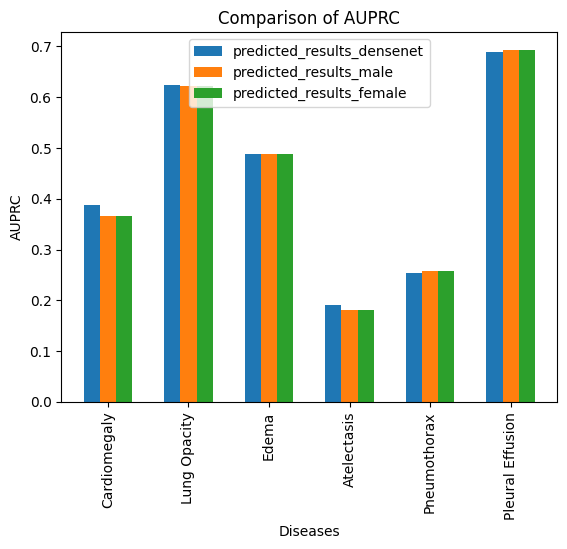

In [75]:

# Extract diseases and AUC values
diseases_to_plot = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases_to_plot]
values_male = [auc_female[disease] for disease in diseases_to_plot]
values_female = [auc_female[disease] for disease in diseases_to_plot]

# Setting the positions and width for the bars
positions = np.arange(len(diseases_to_plot))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions, values_male, width=bar_width, label='predicted_results_male')
bar4 = ax.bar(positions + bar_width, values_female, width=bar_width, label='predicted_results_female')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()


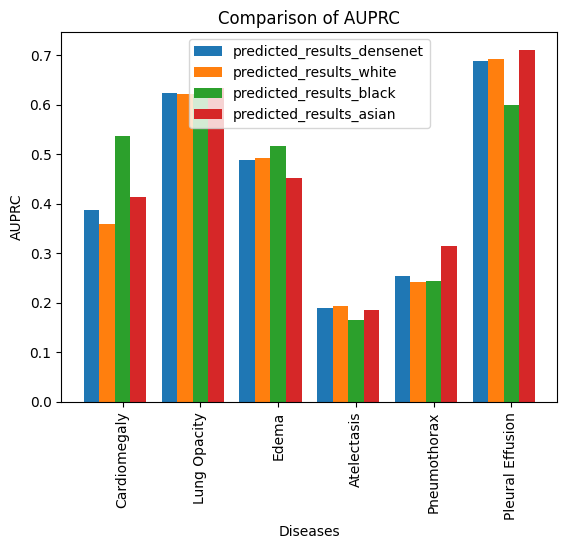

In [76]:

# Extract diseases and AUC values
diseases = list(auc_general.keys())
values2 = [auc_general[disease] for disease in diseases]
values_white = [auc_white[disease] for disease in diseases]
values_black = [auc_black[disease] for disease in diseases]
values_asian = [auc_asian[disease] for disease in diseases]

# Setting the positions and width for the bars
positions = np.arange(len(diseases))
bar_width = 0.2

# Plotting the bars
fig, ax = plt.subplots()
bar2 = ax.bar(positions - 2*bar_width, values2, width=bar_width, label='predicted_results_densenet')
bar3 = ax.bar(positions - bar_width, values_white, width=bar_width, label='predicted_results_white')
bar4 = ax.bar(positions, values_black, width=bar_width, label='predicted_results_black')
bar5 = ax.bar(positions + bar_width, values_asian, width=bar_width, label='predicted_results_asian')


# Adding some text for labels, title, and axes ticks
ax.set_xlabel('Diseases')
ax.set_ylabel(met)
ax.set_title(f'Comparison of {met}')
ax.set_xticks(positions)
ax.set_xticklabels(diseases, rotation='vertical')  # Rotating labels vertically
ax.legend()

# Show the plot
plt.show()
